# Prop Firm Project
#### Created By: Stefan & Enrico

##### 1. Import Signal files

In [4]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from scipy.optimize import minimize
import plotly.graph_objs as go
import plotly.io as pio
import ipywidgets as widgets
from IPython.display import display

In [5]:
path = r'C:\Laptop Data\Business\Capital Market\Prop Firm\Web Scrap\Consolidate Signal\*.xlsx'
signal_path = glob.glob(path)
signal_dfs = []

for i in signal_path:
    df = pd.read_excel(i)
    signal_dfs.append(df)

In [6]:
# Print Signal
for idx, df in enumerate(signal_dfs):
    print(f"DataFrame {idx + 1} - First 5 Rows:")
    print(df.head())
    print("\n" + "="*50 + "\n")


DataFrame 1 - First 5 Rows:
          Create Date  Symbol Order Type  Open Price           Open Time  \
0 2022-09-06 07:39:00  AUDUSD        Buy     0.67981 2022-09-06 10:57:00   
1 2022-09-07 06:04:00  NZDUSD       Sell     0.60600 2022-09-08 00:22:00   
2 2022-09-07 06:09:00  XAUUSD       Sell  1707.87000 2022-09-07 21:28:00   
3 2022-09-07 06:13:00  USDCHF        Buy     0.98300 2022-09-07 14:56:00   
4 2022-09-08 06:57:00  GBPJPY        Buy   165.19500 2022-09-08 14:32:00   

    Pips          Close Time  
0  -29.8 2022-09-06 15:35:00  
1  -71.1 2022-09-09 14:57:00  
2 -130.0 2022-09-08 14:01:00  
3  -76.8 2022-09-08 13:06:00  
4  194.3 2022-09-13 19:30:00  


DataFrame 2 - First 5 Rows:
          Create Time  Symbol Order Type  Open Price           Open Time  \
0 2022-09-15 22:20:00  AUDUSD        Buy     0.66816 2022-09-16 14:46:00   
1 2022-09-19 10:52:00  XAUUSD        Buy  1665.50000 2022-09-19 13:08:00   
2 2022-09-20 02:54:00  USDJPY        Buy   143.50000 2022-09-20 14:34:0

##### 2. Making of Equity Curve

In [8]:
def generate_equity_curve(start_dates, end_dates, profit_loss):
    # Ensure the time columns are in datetime format
    start_dates = pd.to_datetime(start_dates)
    end_dates = pd.to_datetime(end_dates)
    
    # Create a DataFrame from the inputs
    df = pd.DataFrame({'start_date': start_dates, 'end_date': end_dates, 'profit_loss': profit_loss})

    # Create a date range that covers the entire period
    date_range = pd.date_range(start=start_dates.min(), end=end_dates.max(), freq='H')

    # Initialize a DataFrame to hold the equity curve
    equity_curve = pd.DataFrame(date_range, columns=['time'])
    equity_curve['equity'] = 0.0

    # Iterate over each trade in the DataFrame
    for index, row in df.iterrows():
        # Create a mask for the date range that falls between start_date and end_date
        mask = (equity_curve['time'] > row['start_date']) & (equity_curve['time'] <= row['end_date'])

        # Calculate the total hours between start_date and end_date
        total_hours = (row['end_date'] - row['start_date']).total_seconds() / 3600  # Convert seconds to hours
        
        # Calculate the hourly profit/loss for this trade
        hourly_profit = row['profit_loss'] / total_hours if total_hours > 0 else 0

        # Apply the hourly profit to the relevant dates in the equity curve
        equity_curve.loc[mask, 'equity'] += hourly_profit

    # Calculate the cumulative equity
    equity_curve['equity'] = equity_curve['equity'].cumsum()

    return equity_curve

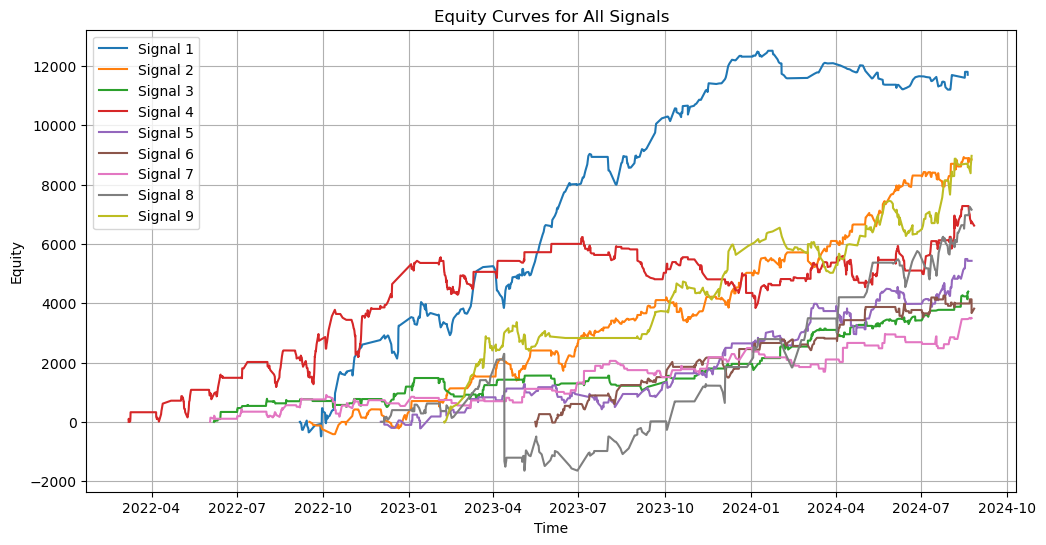

In [9]:
# Create a plot for all equity curves
plt.figure(figsize=(12, 6))

# Initialize a DataFrame for storing profit/loss data
profit_loss_data = pd.DataFrame()

# Loop through each DataFrame and plot the equity curves
for i in range(len(signal_dfs)):
    start_date = signal_dfs[i]['Open Time']
    end_date = signal_dfs[i]['Close Time']
    profit_loss = signal_dfs[i]['Pips']
    
    equity_curve = generate_equity_curve(start_date, end_date, profit_loss)
    
    # Plot each equity curve
    plt.plot(equity_curve['time'], equity_curve['equity'], label=f'Signal {i + 1}')
    
    # Add profit/loss data to the DataFrame
    profit_loss_data[f'Signal {i + 1}'] = profit_loss
    
# Customize the plot
plt.xlabel('Time')
plt.ylabel('Equity')
plt.title('Equity Curves for All Signals')
plt.legend()
plt.grid(True)
plt.show()

##### 3. Data Analysis

###### 3.1 Correlation Matrix

          Signal 1  Signal 2  Signal 3  Signal 4  Signal 5  Signal 6  \
Signal 1  1.000000  0.014578  0.089117  0.122396 -0.023461  0.009479   
Signal 2  0.014578  1.000000  0.010488 -0.004522 -0.044250  0.040410   
Signal 3  0.089117  0.010488  1.000000 -0.032844 -0.068302  0.029325   
Signal 4  0.122396 -0.004522 -0.032844  1.000000 -0.083052  0.018109   
Signal 5 -0.023461 -0.044250 -0.068302 -0.083052  1.000000  0.009731   
Signal 6  0.009479  0.040410  0.029325  0.018109  0.009731  1.000000   
Signal 7  0.068606 -0.030848  0.163811  0.089855  0.037976  0.018522   
Signal 8 -0.076887 -0.028977 -0.097801 -0.004065  0.065672 -0.115472   
Signal 9 -0.068975  0.011434 -0.000142 -0.012821 -0.029451 -0.014899   

          Signal 7  Signal 8  Signal 9  
Signal 1  0.068606 -0.076887 -0.068975  
Signal 2 -0.030848 -0.028977  0.011434  
Signal 3  0.163811 -0.097801 -0.000142  
Signal 4  0.089855 -0.004065 -0.012821  
Signal 5  0.037976  0.065672 -0.029451  
Signal 6  0.018522 -0.115472 -0.0

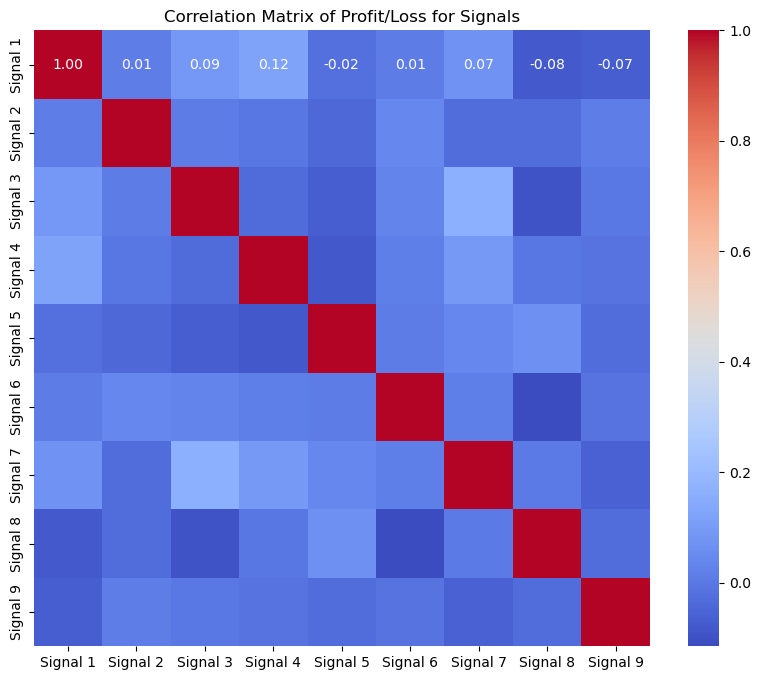

In [12]:
# Making of Correlation Matrix
correlation_matrix = profit_loss_data.corr()
print(correlation_matrix)

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Profit/Loss for Signals')
plt.show()


###### 3.2 Show Average Profit & Drawdown

In [14]:
def calculate_avg_profit_and_max_drawdown(signal_df):
    start_date = pd.to_datetime(signal_df['Open Time'])
    end_date = pd.to_datetime(signal_df['Close Time'])
    profit_loss = signal_df['Pips']
    
    total_profit = profit_loss.sum()
    num_days = (end_date.max() - start_date.min()).days + 1
    
    avg_profit = total_profit / num_days if num_days > 0 else 0  # Avoid division by zero
    
    # Calculate cumulative profit/loss
    cumulative_profit_loss = profit_loss.cumsum()
    
    # Calculate maximum drawdown
    max_drawdown = 0
    peak = cumulative_profit_loss[0]

    for value in cumulative_profit_loss:
        if value > peak:
            peak = value
        drawdown = peak - value
        max_drawdown = max(max_drawdown, drawdown)
    
    return avg_profit, max_drawdown

In [15]:
average_profits = []
max_drawdowns = []

for i in range(len(signal_dfs)):
    avg_profit, max_drawdown = calculate_avg_profit_and_max_drawdown(signal_dfs[i])
    average_profits.append(avg_profit)
    max_drawdowns.append(max_drawdown)

In [16]:
# Convert to pandas Series for easier calculations
average_profits = pd.Series(average_profits)
max_drawdowns = pd.Series(max_drawdowns)

print(average_profits)
print(max_drawdowns)
print(average_profits*30/max_drawdowns)

0    17.428011
1    11.909463
2     5.089950
3     8.079956
4     8.996677
5     8.413433
6     3.657371
7    16.131062
8    16.989716
dtype: float64
0    1671.4
1     808.8
2     699.2
3    1528.0
4     850.7
5     996.9
6     736.6
7    1299.5
8    1613.7
dtype: float64
0    0.312816
1    0.441746
2    0.218390
3    0.158638
4    0.317269
5    0.253188
6    0.148956
7    0.372399
8    0.315853
dtype: float64


###### 3.3 Making of Portfolio

In [18]:
def calculate_combined_equity(signal_1_weight, signal_2_weight, signal_3_weight):
    signal_weights = {
        2: signal_1_weight,
        5: signal_2_weight,
        8: signal_3_weight
    }

    combined_equity = None

    for signal_idx, weight in signal_weights.items():
        start_date = signal_dfs[signal_idx - 1]['Open Time']
        end_date = signal_dfs[signal_idx - 1]['Close Time']
        profit_loss = signal_dfs[signal_idx - 1]['Pips'] * weight
        
        equity_curve = generate_equity_curve(start_date, end_date, profit_loss)
        
        if combined_equity is None:
            combined_equity = equity_curve.copy()
        else:
            combined_equity['equity'] += equity_curve['equity']

    return combined_equity

In [19]:
def update_plot(signal_1_weight, signal_2_weight, signal_3_weight):
    combined_equity = calculate_combined_equity(signal_1_weight, signal_2_weight, signal_3_weight)

    # Calculate metrics
    # Calculate total profit and the number of days
    total_profit = combined_equity['equity'].max()
    num_days = (combined_equity['time'].max() - combined_equity['time'].min()).days + 1
    stdev = combined_equity['equity'].std()
    
    # Calculate average profit per day
    avg_profit = total_profit / num_days
    
    # Calculate cumulative profit/loss
    cumulative_profit_loss = combined_equity['equity']
    
    # Calculate maximum drawdown
    max_drawdown = 0
    peak = cumulative_profit_loss[0]

    for value in cumulative_profit_loss:
        if value > peak:
            peak = value
        drawdown = peak - value
        max_drawdown = max(max_drawdown, drawdown)
    print(total_profit)
    print(num_days)
    print("Average profit per month:",avg_profit*30)
    print("Max Drawdown:",max_drawdown)
    print("Standard Deviation:",stdev)
    print(avg_profit*1000/stdev)
    
    plt.figure(figsize=(12, 6))
    plt.plot(combined_equity['time'], combined_equity['equity'], label='Portfolio Equity')
    plt.xlabel('Time')
    plt.ylabel('Equity')
    plt.title(f'Portfolio Equity Curve\nAvg Profit / Max Drawdown: {avg_profit*30/max_drawdown:.2f}\nAvg Profit / Stdev: {avg_profit*1000/stdev:.2f}')
    plt.grid(True)
    plt.legend()
    plt.show()

# Create sliders for adjusting signal weights
signal_1_slider = widgets.FloatSlider(value=0.2, min=0, max=1, step=0.1, description='Signal 2 Weight:')
signal_2_slider = widgets.FloatSlider(value=0.7, min=0, max=1, step=0.1, description='Signal 5 Weight:')
signal_3_slider = widgets.FloatSlider(value=0.1, min=0, max=1, step=0.1, description='Signal 8 Weight:')

# Create interactive plot
widgets.interact(update_plot, signal_1_weight=signal_1_slider, signal_2_weight=signal_2_slider, signal_3_weight=signal_3_slider)

interactive(children=(FloatSlider(value=0.2, description='Signal 2 Weight:', max=1.0), FloatSlider(value=0.7, …

<function __main__.update_plot(signal_1_weight, signal_2_weight, signal_3_weight)>